### In this notebook, we will try to implement the chatbot using the RAG method. The RAG methods works perfectly with text data. It doesn't do that advanced calculations. However, let's give it a try and play with its parameters.

### Loading Data 

We are loading the dataset. 
Since RAG mainly works with text data, here each row is considered as a "document"

In [1]:
from langchain.document_loaders.csv_loader import CSVLoader
loader = CSVLoader(file_path=r"Loading_PreprocessingData/filtered_data.csv")
chronic_df = loader.load()

In [2]:
## example this is the first row
chronic_df[0]

Document(page_content='YearStart: 2014\nYearEnd: 2014\nLocationAbbr: AR\nLocationDesc: Arkansas\nDataSource: SEDD; SID\nTopic: Asthma\nQuestion: Hospitalizations for asthma\nDataValueUnit: \nDataValueType: Number\nDataValue: 916\nDataValueFootnoteSymbol: \nDatavalueFootnote: \nLowConfidenceLimit: \nHighConfidenceLimit: \nStratificationCategory1: Gender\nStratification1: Male\nGeoLocation: POINT (-92.27449074299966 34.74865012400045)\nProcessedDataValue: \nProcessedDataValue_z_score: ', metadata={'source': 'Loading_PreprocessingData/filtered_data.csv', 'row': 0})

In the RAG approach, it is common to have a splitting phase. You can split documents by chunk size or by a common seperator.

### Embedding

In the embedding section, we convert our documents to embeddings and store them in a vector database. We are using HuggingFaceEmbeddings.
Make sure to add your credentials

In [3]:
#pip install sentence-transformers
from langchain.embeddings import HuggingFaceEmbeddings
import requests

model_id = "sentence-transformers/all-MiniLM-L6-v2"

hf_token = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"

api_url = f"https://api-inference.huggingface.co/pipeline/feature-extraction/{model_id}"

headers = {"Authorization": f"Bearer {hf_token}"}

model_id = 'sentence-transformers/all-MiniLM-L6-v2'

model_kwargs = {'device': 'cpu'}

embedding = HuggingFaceEmbeddings(model_name=model_id,model_kwargs=model_kwargs)

### Vector Storing

Now, we are going to apply our embeddings and insert them into a vector database.
There are multiple parameters for these methods and other functions to be used in the LangChain documentation, which we highly encourage you to try out yourself.

We will just take a small sample from the dataset to reduce execution time.

In [4]:
from langchain.vectorstores.docarray import DocArrayInMemorySearch

In [5]:
import pandas as pd
idx = list(pd.DataFrame(chronic_df).sample(1000, random_state = 42).index) ## saving the idx for later usage and to enhance performance
sampled_df = [chronic_df[i] for i in idx]

In [6]:
k = 7
db = DocArrayInMemorySearch.from_documents(sampled_df, embedding)

## in retrieval it will get the most 7 similar items
## you can guess the RAG limitations now.

retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": k})

### LLM settings

Let's initialize our GPT-4 model.
Make sure to use your credentials

In [7]:
from langchain.chat_models.azure_openai import AzureChatOpenAI

llm =  AzureChatOpenAI(
    openai_api_type = "azure",
    openai_api_base = "https://xxxxxxxxxxxxxxx.openai.azure.com/",
    openai_api_version = "xxxx-xx-xx-preview",
    deployment_name='GPT-4',
    openai_api_key = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxx")

### Memory

This is a buffer for storing a conversation in-memory and then retrieving the messages at a later time. It we will be useful for our chatbot. As mentioned before, there are multiple functions to try in each section.

In [8]:
from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True
)

### Prompt

Prepare prompt template that will be fed to the RAG

In [9]:
# Build prompt
from langchain.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end. Keep the answer as concise as possible. Be nice and friendly and answer to greetings.
{context}
Question: {question}
Helpful Answer:"""
QA_CHAIN_PROMPT = PromptTemplate(input_variables=["context", "question"],template=template,)

### Chain

Now, we are going to chain everything together.

In [10]:
from langchain.chains import ConversationalRetrievalChain

qa = ConversationalRetrievalChain.from_llm(
    llm = llm, # model
    retriever=retriever, # the vector db
    verbose = False, # for tracking how it works .. = True if you want to experiment.
    memory=memory,    # memory buffer
)

# We don't have to worry about initializing the prompt inside the function. It's already embedded.

### Interface

It's time to build the chatbot interface

In [11]:
from langchain.schema import AIMessage, HumanMessage
import openai
import time
import gradio as gr

def predict(message, history):
    history_langchain_format = []
    for human, ai in history:
        history_langchain_format.append(HumanMessage(content=human))
        history_langchain_format.append(AIMessage(content=ai))
    history_langchain_format.append(HumanMessage(content=message))
    
    gpt_response = qa({"question": message})
    
    
    response_message = ""
    for character in gpt_response['answer']:
        response_message += character
        time.sleep(0.02)
        yield response_message
    

chat_interface = gr.ChatInterface(predict)

chat_interface.queue()

chat_interface.launch()

Running on local URL:  http://127.0.0.1:7878

To create a public link, set `share=True` in `launch()`.


Try the chatbot yourself!

Here is a sample of the output.

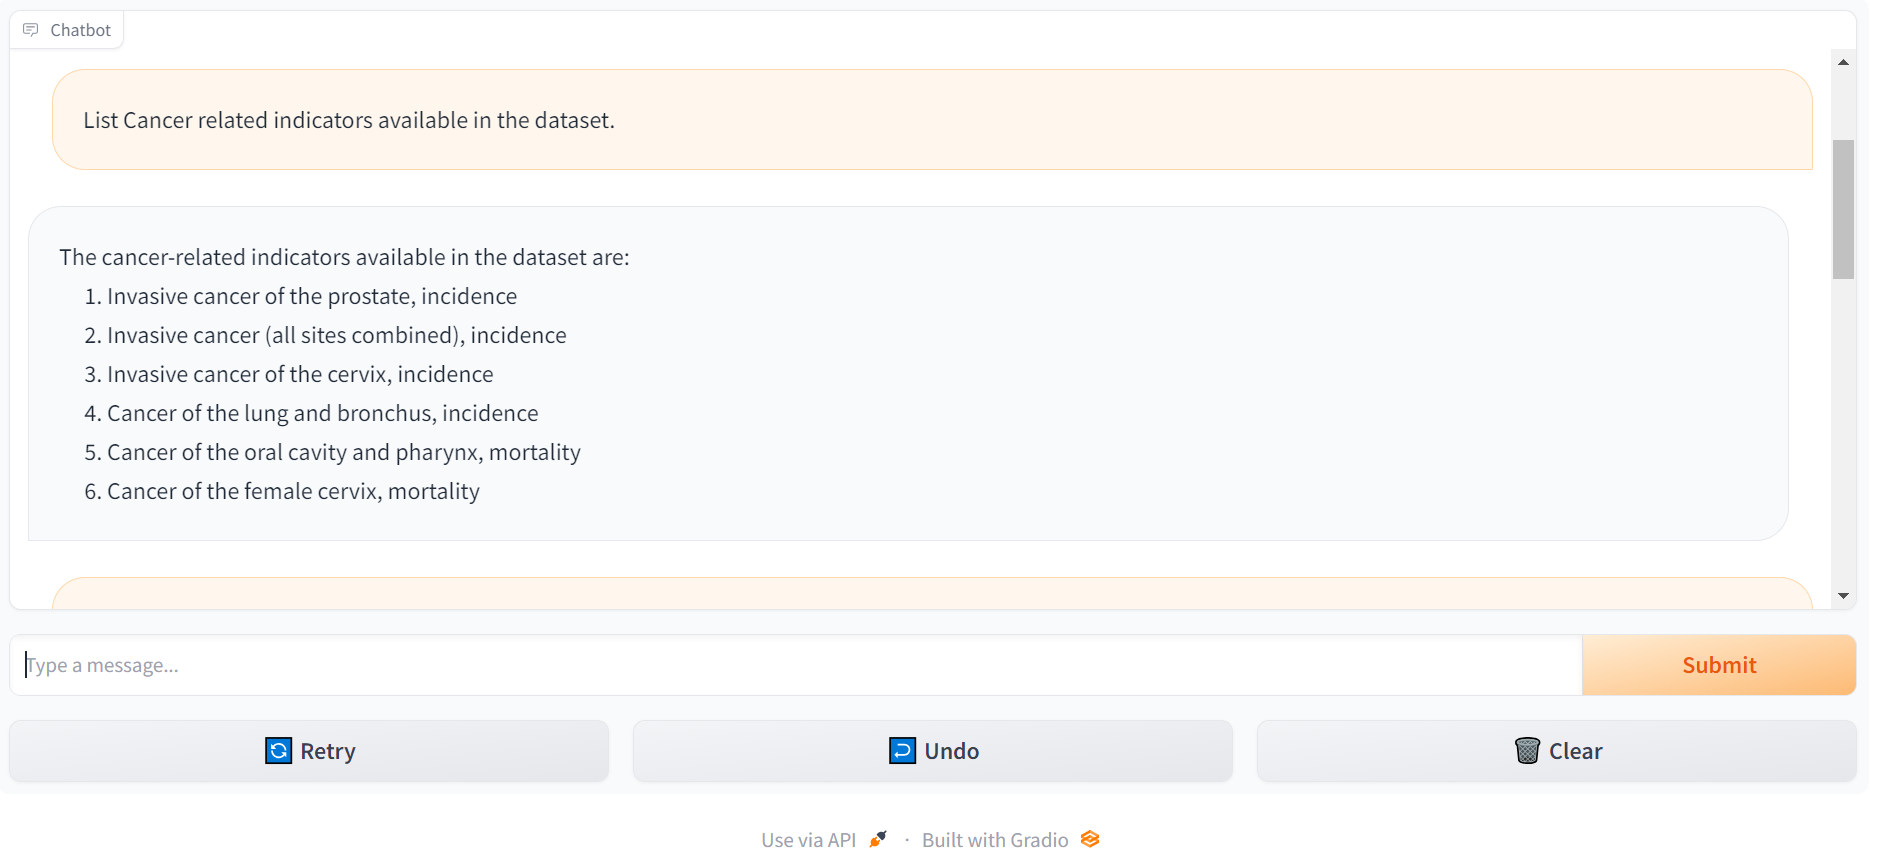

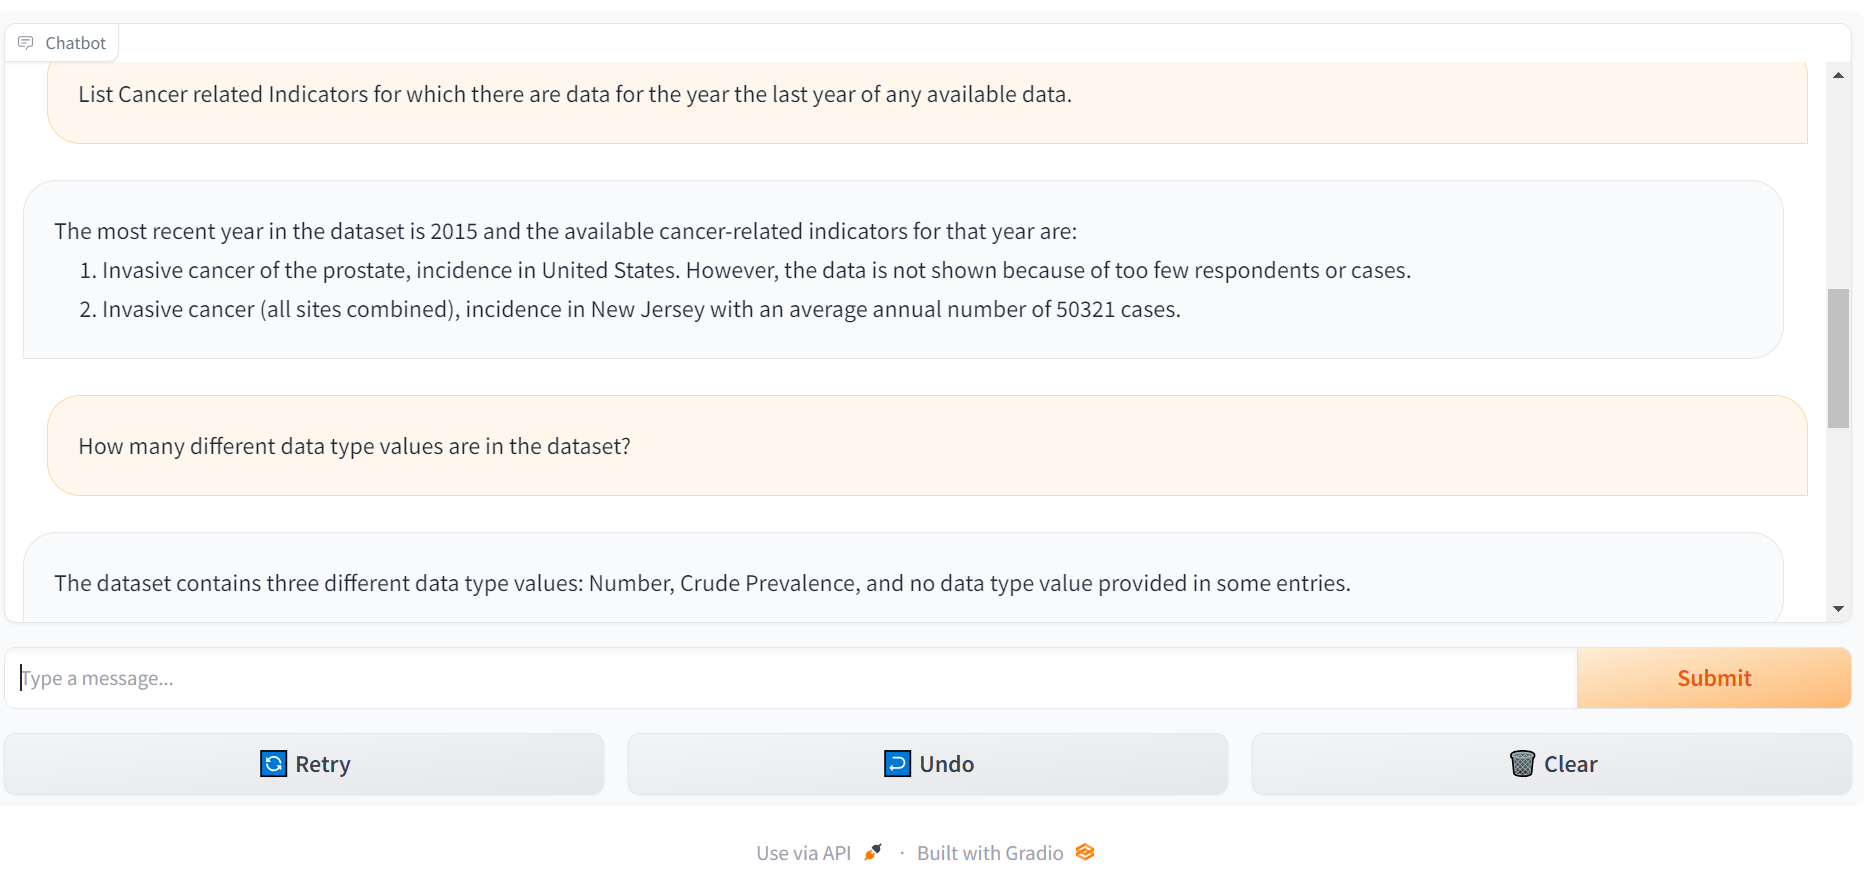

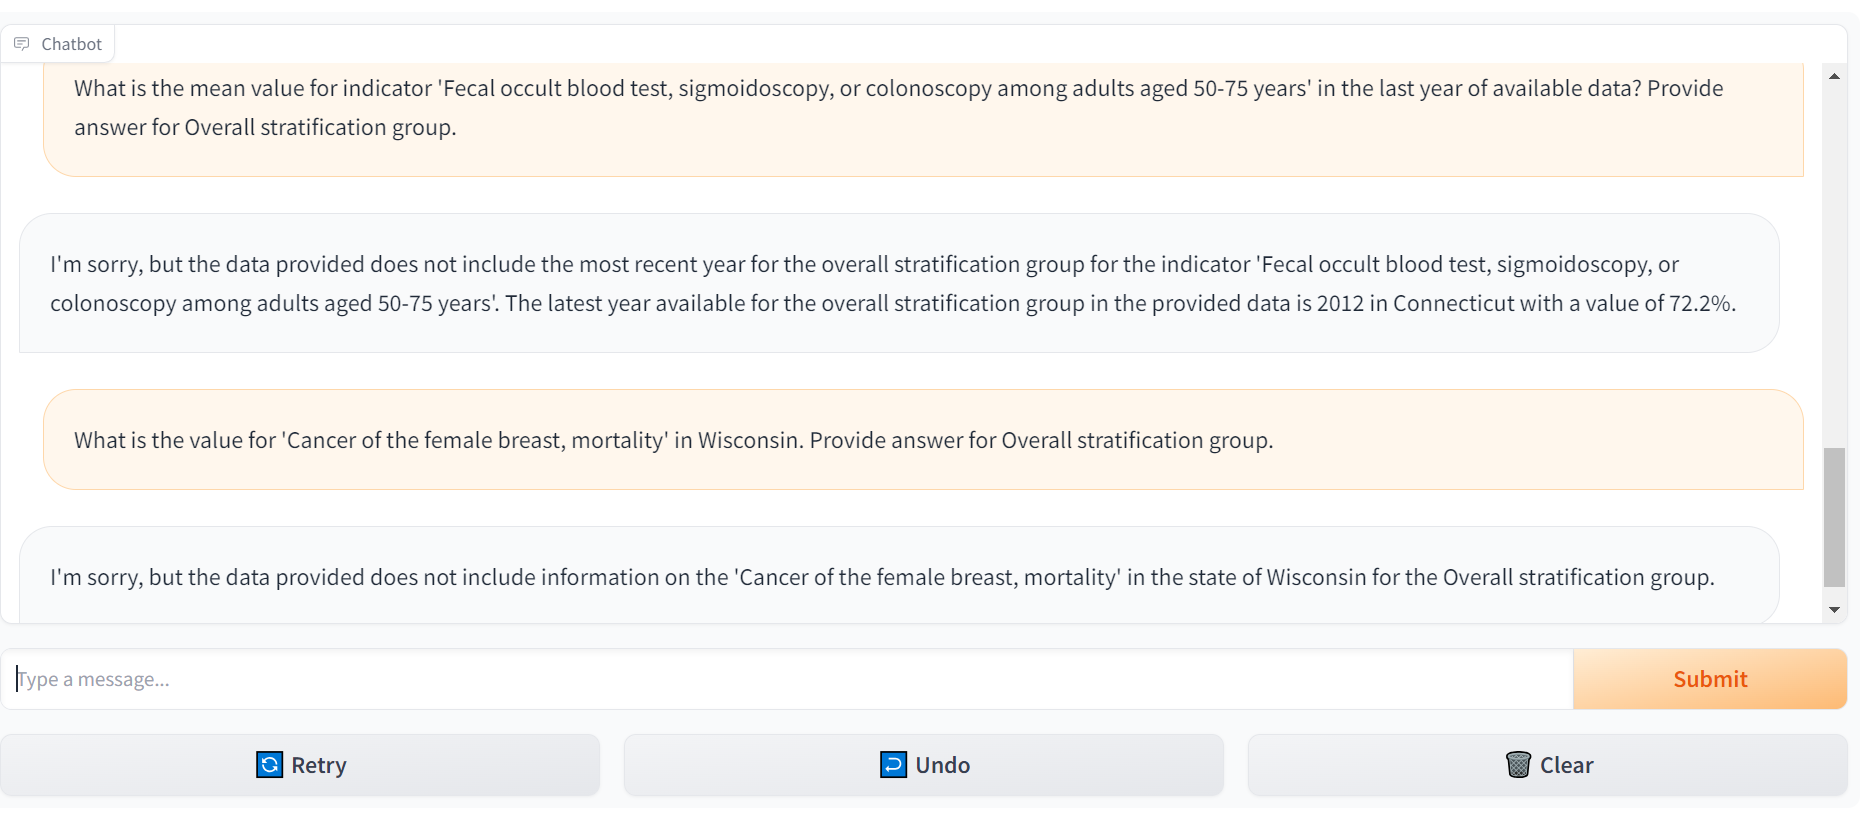

Let's see the actual answers!

In [12]:
## read our pandas df
# filter our df from the sampled data

df = pd.read_csv("Loading_PreprocessingData/filtered_data.csv", low_memory = False)
df = df.loc[idx]

In [13]:
# List Cancer related indicators available in the dataset.

answer_1 = df[df.Topic == 'Cancer']['Question'].unique()
answer_1

array(['Cancer of the female breast, mortality',
       'Invasive cancer of the oral cavity or pharynx, incidence',
       'Cancer of the prostate, mortality', 'Melanoma, mortality',
       'Invasive cancer (all sites combined), incidence',
       'Invasive melanoma, incidence',
       'Fecal occult blood test, sigmoidoscopy, or colonoscopy among adults aged 50-75 years',
       'Invasive cancer of the female breast, incidence',
       'Invasive cancer of the cervix, incidence',
       'Cancer of the colon and rectum (colorectal), mortality',
       'Cancer of the oral cavity and pharynx, mortality',
       'Cancer of the female cervix, mortality',
       'Papanicolaou smear use among adult women aged 21-65 years',
       'Invasive cancer (all sites combined), mortality',
       'Recent Papanicolaou smear use among women aged 21-44 years',
       'Invasive cancer of the prostate, incidence',
       'Cancer of the lung and bronchus, mortality',
       'Cancer of the colon and rectum (co

In [14]:
# List Cancer related Indicators for which there are data for the year the last year of any available data.
answer_2 =  len(df[(df.Topic == 'Cancer') & (df.YearStart == df.YearStart.max())])
answer_2

0

In [15]:
# How many diferent datatypes are in the dataset?
answer_3 = len(df['DataValueType'].unique())
answer_3

9

In [16]:
# What is the mean value for indicator 'Fecal occult blood test, sigmoidoscopy, or colonoscopy among adults aged 50-75 years' in the last year of available data? Provide answer for Overall stratification group.

max_year = df[df.Question == 'Fecal occult blood test, sigmoidoscopy, or colonoscopy among adults aged 50-75 years']['YearStart'].max()

answer_4 = df[(df.Question == 'Fecal occult blood test, sigmoidoscopy, or colonoscopy among adults aged 50-75 years') & (df.YearStart == max_year) & (df.Stratification1 == "Overall")]['DataValue'].mean()
answer_4

nan

In [17]:
# What is the value for 'Cancer of the female breast, mortality' in Wisconsin. Provide answer for Overall stratification group.

answer_5 = df[(df.Question == 'Cancer of the female breast, mortality') & (df.Stratification1 == 'Overall') & (df.LocationAbbr == 'WI')][['YearStart', 'YearEnd', 'DataValue']].sort_values(by='YearStart', ascending=False)
answer_5

,YearStart,YearEnd,DataValue


RAG works by selecting the most similar seven documents (as specified) and attempts to create a summary from them. That's why, even though it can retrieve an answer, it is incomplete (for example, the first question displays only six cancer indicators, while the actual count is more than that).

As you can observe from the subpar results, RAG is not recommended in this case. It can be particularly useful in very straightforward datasets with basic questions (e.g., inquiring about certain state values) or if the dataset itself contains text data (e.g., news data).

The advantage of RAG, aside from being ideal for text data, is that it consumes fewer tokens, resulting in lower costs. In contrast, the PandasAgent generates code while thinking all of this involves more tokens.